# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
!pip install --upgrade ipywidgets
!pip install --upgrade jupyter

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 138 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 33.1 MB/s eta 0:00:01
     |████████████████████████████████| 214 kB 42.7 MB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 121 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 385 kB 40.4 MB/s eta 0:00:01


ERROR: jupyter-console 6.6.3 has requirement ipykernel>=6.14, but you'll have ipykernel 5.1.4 which is incompatible.
ERROR: jupyter-console 6.6.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 6.0.0 which is incompatible.
ERROR: jupyter-console 6.6.3 has requirement jupyter-core!=5.0.*,>=4.12, but you'll have jupyter-core 4.6.3 which is incompatible.
ERROR: jupyter-console 6.6.3 has requirement traitlets>=5.4, but you'll have traitlets 4.3.3 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from tqdm import tqdm

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
#  number of subprocesses to use for data loading, here, I set to equal number of cpus available
num_workers = multiprocessing.cpu_count()

# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Create training set and define training dataloader
train_val_datasets = torchvision.datasets.MNIST(root = "data", download = True, train = True, transform = transform)

len_training_datasets = int(len(train_val_datasets)*0.8)
len_val_datasets = len(train_val_datasets) - len_training_datasets


training_datasets, val_datatasets = torch.utils.data.random_split(train_val_datasets, [len_training_datasets, len_val_datasets], generator = torch.Generator().manual_seed(42))

training_dataloader = torch.utils.data.DataLoader(training_datasets, batch_size = 64, shuffle = True, num_workers = num_workers)

val_dataloader = torch.utils.data.DataLoader(val_datatasets, batch_size = 64, shuffle = False, num_workers = num_workers )

# Create test set and define test dataloader
test_datasets = torchvision.datasets.MNIST(root = "data", download = True, train = False, transform = transform)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size = 64, shuffle = False, num_workers = num_workers)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**** I chose normalization transformation simply because I want to convert the pixels value from 0-255 to -1 t0 1 for better application of gradient functions and optimization. I also used ToTensor transformation to move the arrays from numpy or PIL_Image to tensor arrays for pytorch use. I flatten the data from 2D matrix into vector to allow forward feeding into the model as required by multilayer perceptron (MLP). ****

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


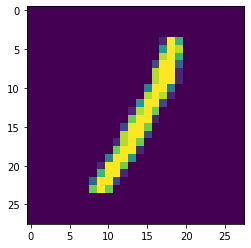

2


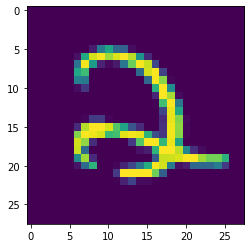

3


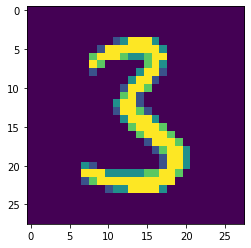

7


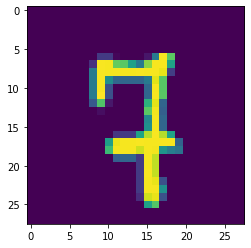

9


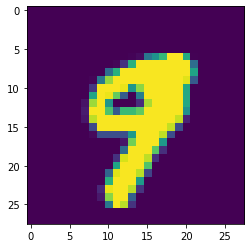

In [5]:
# Explore data
show5(training_dataloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
from collections import OrderedDict
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.relu = F.relu
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(1*28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    def forward(self, x):
        x = torch.flatten(x , 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 1)
        return x


model = Classifier()


In [9]:

optimizer = optim.SGD(model.parameters(), lr = 0.003, momentum = 0.09, weight_decay = 1e-10 )

criterion = nn.NLLLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
train_loss_history = []
best_val_loss = float("inf")
thresh= 0.001
below_threshold = 0
patience = 2

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0

    for batch_idx, (data, labels) in tqdm(enumerate(training_dataloader), desc = "Training", total = len(training_dataloader), leave = True, ncols=80):


        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        input = data.view(data.size(0), -1)



        outputs = model(input)
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()
        
        train_loss += loss.item()
        
        ps = torch.exp(outputs)
        top_ps, top_class = ps.topk(1, dim=1)
        equality = top_class == labels.view(*top_class.shape)
        train_correct += torch.mean(equality.type(torch.FloatTensor))
        
    print("Epoch {} training accuracy: {:.2f}% training loss: {:.2f}".format(epoch + 1, (train_correct/len(training_dataloader))*100, (train_loss/len(training_dataloader))))
    train_loss_history.append(train_loss/len(training_dataloader))

    with torch.no_grad():
      val_loss = 0.0
      val_correct = 0
      val_loss_history = []

      model.eval()
      for batch_idx, (inputs, labels) in tqdm(enumerate(val_dataloader), desc = "Validating", total = len(val_dataloader), leave = True, ncols=80):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        v_output = model(inputs)
        v_loss = criterion(v_output, labels)
        val_loss += v_loss
        
        ps = torch.exp(v_output)
        top_ps, top_class = ps.topk(1, dim=1)
        equality = top_class == labels.view(*top_class.shape)
        val_correct += torch.mean(equality.type(torch.FloatTensor))
           
      print("Epoch {} validation accuracy: {:.2f}% validation loss: {:.2f}".format(epoch + 1, (val_correct/len(val_dataloader))*100, (val_loss/len(val_dataloader))))
      val_loss_history.append(val_loss/len(val_dataloader))
      diff = best_val_loss - val_loss
      if best_val_loss > val_loss:
        best_val_loss = val_loss

    if diff <= thresh:
      below_threshold += 1
      if below_threshold >= patience:
        break


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 70.58it/s]

Epoch 1 training accuracy: 29.19% training loss: 2.24



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 83.31it/s]

Epoch 1 validation accuracy: 49.38% validation loss: 2.12



Training: 100%|███████████████████████████████| 750/750 [00:09<00:00, 75.53it/s]

Epoch 2 training accuracy: 56.99% training loss: 1.71



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.86it/s]

Epoch 2 validation accuracy: 71.20% validation loss: 1.18



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 74.63it/s]

Epoch 3 training accuracy: 76.51% training loss: 0.87



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 73.11it/s]


Epoch 3 validation accuracy: 81.73% validation loss: 0.68


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 71.40it/s]

Epoch 4 training accuracy: 84.01% training loss: 0.57



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 77.64it/s]

Epoch 4 validation accuracy: 85.28% validation loss: 0.51



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 73.52it/s]

Epoch 5 training accuracy: 86.86% training loss: 0.46



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 70.57it/s]


Epoch 5 validation accuracy: 87.08% validation loss: 0.44


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 73.30it/s]

Epoch 6 training accuracy: 88.27% training loss: 0.41



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 73.71it/s]

Epoch 6 validation accuracy: 88.09% validation loss: 0.41



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 69.06it/s]

Epoch 7 training accuracy: 89.29% training loss: 0.38



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 73.97it/s]

Epoch 7 validation accuracy: 88.83% validation loss: 0.38



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 69.99it/s]

Epoch 8 training accuracy: 89.92% training loss: 0.35



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.11it/s]

Epoch 8 validation accuracy: 89.50% validation loss: 0.36



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 67.81it/s]

Epoch 9 training accuracy: 90.38% training loss: 0.33



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 78.29it/s]

Epoch 9 validation accuracy: 89.89% validation loss: 0.35



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 71.84it/s]

Epoch 10 training accuracy: 90.80% training loss: 0.32



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.96it/s]

Epoch 10 validation accuracy: 90.28% validation loss: 0.34



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 73.21it/s]

Epoch 11 training accuracy: 91.14% training loss: 0.31



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 66.15it/s]

Epoch 11 validation accuracy: 90.72% validation loss: 0.32



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 68.12it/s]

Epoch 12 training accuracy: 91.41% training loss: 0.30



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 72.00it/s]


Epoch 12 validation accuracy: 90.99% validation loss: 0.31


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 68.73it/s]

Epoch 13 training accuracy: 91.63% training loss: 0.29



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 67.14it/s]

Epoch 13 validation accuracy: 91.16% validation loss: 0.31



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 67.92it/s]

Epoch 14 training accuracy: 91.96% training loss: 0.28



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 68.30it/s]

Epoch 14 validation accuracy: 91.30% validation loss: 0.30



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 63.56it/s]

Epoch 15 training accuracy: 92.10% training loss: 0.27



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.53it/s]

Epoch 15 validation accuracy: 91.58% validation loss: 0.29



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 68.10it/s]

Epoch 16 training accuracy: 92.35% training loss: 0.26



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.25it/s]

Epoch 16 validation accuracy: 91.85% validation loss: 0.28



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 66.78it/s]

Epoch 17 training accuracy: 92.60% training loss: 0.25



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.69it/s]

Epoch 17 validation accuracy: 91.91% validation loss: 0.28



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 67.88it/s]

Epoch 18 training accuracy: 92.78% training loss: 0.25



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 67.99it/s]

Epoch 18 validation accuracy: 92.00% validation loss: 0.27



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 65.60it/s]


Epoch 19 training accuracy: 92.98% training loss: 0.24


Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 68.64it/s]

Epoch 19 validation accuracy: 92.46% validation loss: 0.27



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 68.45it/s]

Epoch 20 training accuracy: 93.27% training loss: 0.23



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.34it/s]

Epoch 20 validation accuracy: 92.40% validation loss: 0.26



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 67.44it/s]

Epoch 21 training accuracy: 93.33% training loss: 0.23



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.45it/s]


Epoch 21 validation accuracy: 92.69% validation loss: 0.25


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 69.17it/s]

Epoch 22 training accuracy: 93.55% training loss: 0.22



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.05it/s]

Epoch 22 validation accuracy: 93.02% validation loss: 0.25



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 66.21it/s]

Epoch 23 training accuracy: 93.75% training loss: 0.21



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.20it/s]

Epoch 23 validation accuracy: 93.08% validation loss: 0.24



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 66.83it/s]

Epoch 24 training accuracy: 93.93% training loss: 0.21



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.14it/s]

Epoch 24 validation accuracy: 93.10% validation loss: 0.24



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 67.91it/s]

Epoch 25 training accuracy: 94.12% training loss: 0.20



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.23it/s]

Epoch 25 validation accuracy: 93.41% validation loss: 0.23



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 69.48it/s]

Epoch 26 training accuracy: 94.24% training loss: 0.20



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 74.96it/s]

Epoch 26 validation accuracy: 93.43% validation loss: 0.22



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 70.61it/s]

Epoch 27 training accuracy: 94.40% training loss: 0.19



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 73.58it/s]

Epoch 27 validation accuracy: 93.66% validation loss: 0.22



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 70.50it/s]


Epoch 28 training accuracy: 94.59% training loss: 0.19


Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.68it/s]


Epoch 28 validation accuracy: 93.77% validation loss: 0.21


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 70.48it/s]

Epoch 29 training accuracy: 94.75% training loss: 0.18



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.44it/s]

Epoch 29 validation accuracy: 93.75% validation loss: 0.21



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 74.72it/s]

Epoch 30 training accuracy: 94.92% training loss: 0.18



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.78it/s]

Epoch 30 validation accuracy: 93.87% validation loss: 0.21


Plot the training loss (and validation loss/accuracy, if recorded).

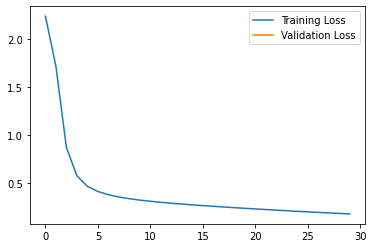

In [11]:
## YOUR CODE HERE ##
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
# Initialize lists to monitor test loss and accuracy
test_loss = 0.0
test_correct = 0.0

# evaluation mode
model.eval()

for i, data in enumerate(test_dataloader):
    inputs, labels = data
    
    #forward pass
    output = model(inputs)
    
    #calculate the loss
    loss = criterion(output, labels)
    
    test_loss += loss.item()
    ps = torch.exp(output)
    top_ps, top_class = ps.topk(1, dim=1)
    equality = top_class == labels.view(*top_class.shape)
    test_correct += torch.mean(equality.type(torch.FloatTensor))

print("test accuracy: {:.2f}% test loss: {:.2f}%".format((test_correct/len(test_dataloader))*100, (test_loss/len(test_dataloader))*100))

test accuracy: 94.58% test loss: 18.56%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [13]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.09, weight_decay = 1e-5 )

criterion = nn.NLLLoss()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 35
train_loss_history = []
best_val_loss = float("inf")
thresh= 0.001
below_threshold = 0
patience = 2

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0

    for batch_idx, (data, labels) in tqdm(enumerate(training_dataloader), desc = "Training", total = len(training_dataloader), leave = True, ncols=80):


        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        input = data.view(data.size(0), -1)



        outputs = model(input)
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()
        
        train_loss += loss.item()
        
        ps = torch.exp(outputs)
        top_ps, top_class = ps.topk(1, dim=1)
        equality = top_class == labels.view(*top_class.shape)
        train_correct += torch.mean(equality.type(torch.FloatTensor))
        
    print("Epoch {} training accuracy: {:.2f}% training loss: {:.2f}".format(epoch + 1, (train_correct/len(training_dataloader))*100, (train_loss/len(training_dataloader))))
    train_loss_history.append(train_loss/len(training_dataloader))

    with torch.no_grad():
      val_loss = 0.0
      val_correct = 0
      val_loss_history = []

      model.eval()
      for batch_idx, (inputs, labels) in tqdm(enumerate(val_dataloader), desc = "Validating", total = len(val_dataloader), leave = True, ncols=80):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        v_output = model(inputs)
        v_loss = criterion(v_output, labels)
        val_loss += v_loss
        
        ps = torch.exp(v_output)
        top_ps, top_class = ps.topk(1, dim=1)
        equality = top_class == labels.view(*top_class.shape)
        val_correct += torch.mean(equality.type(torch.FloatTensor))
           
      print("Epoch {} validation accuracy: {:.2f}% validation loss: {:.2f}".format(epoch + 1, (val_correct/len(val_dataloader))*100, (val_loss/len(val_dataloader))))
      val_loss_history.append(val_loss/len(val_dataloader))
      diff = best_val_loss - val_loss
      if best_val_loss > val_loss:
        best_val_loss = val_loss

    if diff <= thresh:
      below_threshold += 1
      if below_threshold >= patience:
        break


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 69.36it/s]

Epoch 1 training accuracy: 95.14% training loss: 0.17



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.23it/s]

Epoch 1 validation accuracy: 94.01% validation loss: 0.20



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 66.10it/s]

Epoch 2 training accuracy: 95.20% training loss: 0.17



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 73.95it/s]

Epoch 2 validation accuracy: 93.97% validation loss: 0.20



Training: 100%|███████████████████████████████| 750/750 [00:09<00:00, 75.56it/s]

Epoch 3 training accuracy: 95.19% training loss: 0.17



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 64.13it/s]

Epoch 3 validation accuracy: 94.17% validation loss: 0.20



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 67.34it/s]

Epoch 4 training accuracy: 95.31% training loss: 0.16



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 74.78it/s]


Epoch 4 validation accuracy: 94.18% validation loss: 0.20


Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 68.02it/s]

Epoch 5 training accuracy: 95.34% training loss: 0.16



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 74.90it/s]

Epoch 5 validation accuracy: 94.07% validation loss: 0.20



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 73.95it/s]

Epoch 6 training accuracy: 95.39% training loss: 0.16



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 79.79it/s]


Epoch 6 validation accuracy: 94.22% validation loss: 0.19


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 73.98it/s]

Epoch 7 training accuracy: 95.41% training loss: 0.16



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 74.04it/s]

Epoch 7 validation accuracy: 94.23% validation loss: 0.19



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 74.06it/s]

Epoch 8 training accuracy: 95.47% training loss: 0.16



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 74.85it/s]


Epoch 8 validation accuracy: 94.18% validation loss: 0.19


Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 74.12it/s]

Epoch 9 training accuracy: 95.55% training loss: 0.16



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 79.80it/s]

Epoch 9 validation accuracy: 94.20% validation loss: 0.19



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 68.15it/s]

Epoch 10 training accuracy: 95.54% training loss: 0.15



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 76.55it/s]

Epoch 10 validation accuracy: 94.44% validation loss: 0.19



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 74.07it/s]

Epoch 11 training accuracy: 95.66% training loss: 0.15



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 68.70it/s]

Epoch 11 validation accuracy: 94.37% validation loss: 0.19



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 69.26it/s]

Epoch 12 training accuracy: 95.63% training loss: 0.15



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 73.71it/s]

Epoch 12 validation accuracy: 94.43% validation loss: 0.19



Training: 100%|███████████████████████████████| 750/750 [00:09<00:00, 75.79it/s]

Epoch 13 training accuracy: 95.72% training loss: 0.15



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.18it/s]

Epoch 13 validation accuracy: 94.51% validation loss: 0.18



Training: 100%|███████████████████████████████| 750/750 [00:09<00:00, 76.92it/s]

Epoch 14 training accuracy: 95.72% training loss: 0.15



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 62.99it/s]

Epoch 14 validation accuracy: 94.43% validation loss: 0.18



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 67.39it/s]


Epoch 15 training accuracy: 95.76% training loss: 0.15


Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 77.38it/s]

Epoch 15 validation accuracy: 94.56% validation loss: 0.18



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 71.88it/s]


Epoch 16 training accuracy: 95.79% training loss: 0.15


Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.85it/s]

Epoch 16 validation accuracy: 94.46% validation loss: 0.18



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 73.24it/s]

Epoch 17 training accuracy: 95.85% training loss: 0.14



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 71.44it/s]

Epoch 17 validation accuracy: 94.59% validation loss: 0.18



Training: 100%|███████████████████████████████| 750/750 [00:10<00:00, 70.14it/s]

Epoch 18 training accuracy: 95.87% training loss: 0.14



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 74.56it/s]

Epoch 18 validation accuracy: 94.63% validation loss: 0.18



Training: 100%|███████████████████████████████| 750/750 [00:11<00:00, 66.98it/s]

Epoch 19 training accuracy: 95.91% training loss: 0.14



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 79.39it/s]

Epoch 19 validation accuracy: 94.55% validation loss: 0.18


In [15]:
# Initialize lists to monitor test loss and accuracy
test_loss = 0.0
test_correct = 0.0

# evaluation mode
model.eval()

for i, data in enumerate(test_dataloader):
    inputs, labels = data
    
    #forward pass
    output = model(inputs)
    
    #calculate the loss
    loss = criterion(output, labels)
    
    test_loss += loss.item()
    ps = torch.exp(output)
    top_ps, top_class = ps.topk(1, dim=1)
    equality = top_class == labels.view(*top_class.shape)
    test_correct += torch.mean(equality.type(torch.FloatTensor))

print("test accuracy: {:.2f}% test loss: {:.2f}".format((test_correct/len(test_dataloader))*100, (test_loss/len(test_dataloader))))

test accuracy: 95.23% test loss: 0.16


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
torch.save(model, "model.pth" )